In [1]:
"""
Two-fluid model (Montini 2011, Ferrari 2017)
"""
# Libraries
from fenics import *                                                                    # 
from IPython.display import clear_output                                                # for time steps
from matplotlib import rc
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
from numpy import linalg as LA
from scipy import linalg, matrix, sparse
from scipy.optimize import brenth
from scipy.linalg import eigvals, eig
from scipy.misc import derivative as dtv
from scipy.sparse.linalg import eigs
from scipy.sparse import csr_matrix

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pprint
import time
import ufl

# ===============================================================
# Type of simulation
simulation = 'linear_stability'                 # OPTIONS: linear_stability, stiffness
# For stiffness
withBC = "withbcs"                            # OPTIONS: withbcs, empty
# For "linear stability"
effect = 'linear'                               # OPTIONS: linear, nonlinear
# For linear stability
nonlineartreatment = 'Cahn_Hilliard'            # OPTIONS: 'Cahn_Hilliard', 'regular' 
# Study case
case = 'case2'                          # OPTIONS: case1, case2, case3
# Viscous effects
viscous_terms = "viscid"            # OPTIONS: viscid, inviscid
# CFL method
base_CFL = 'liquid'                             # OPTIONS: liquid, gas, max_velocity
# CFL input 
CFL = 1                                     # 0.7 Holmas, 0.978 Van Zwieten, 0.95 Bonzanini, 1 Sanderse
# Initial conditions
IBVP = 'SS'                                     # OPTIONS: SS , SS_perturbed
# Periodic boundary conditions
dirichlet_type = "nonperiodic"                  # OPTIONS: periodic, nonperiodic
# Pipe inclination
inclination = 'horizontal'                      # OPTIONS: horizontal, upward_straight, downward_straight
# Number of cells and maximum degree of basis functions
nx = 40                                        # element size
p = 2                                           # degree of velocity spaces
# Time integration method
time_method = 'BDF2'                            # OPTIONS: BDF1, BDF2, CN
# Time step method
timestep= "cfl_based"                      # OPTIONS: timestep_input, cfl_based
# For "timestep_input"
dt_input = 1e-5                    
# Final time method
T_simulation = "T_cfl_based"                    # OPTIONS: T_cfl_based, T_input
# For "T_cfl_based"
num_steps = 100
# For "T_input"
T_in = 10 
# Method for liquid volume fraction calculation
var1_method = "correlation"                      # OPTIONS: var1_input, correlation
# For "var1_input"
var1_in = 0.5 + DOLFIN_EPS
# Diameter
D = 0.078                                      # 0.022 # m, diameter
# ===============================================================

# Form compiler options
# parameters ['form_compiler']['representation'] = 'uflacs'
# parameters ["form_compiler"]["optimize"] = True
# parameters ["form_compiler"]["cpp_optimize"] = True
# parameters["std_out_all_processes"] = False; # Print log messages only from the root process in parallel

ffc_options = {"optimize": True, \
               "eliminate_zeros": True, \
               "precompute_basis_const": True, \
               "precompute_ip_const": True}

# parameters ["form_compiler"]['precision'] = 50
# parameters ["form_compiler"]["cpp_optimize_flags"] = "-O3 -ffast-math -march=native"
# parameters ["form_compiler"]["quadrature_degree"] = 8

# parameters["allow_extrapolation"] = True
# parameters["refinement_algorithm"] = "plaza_with_parent_facets"
# parameters["std_out_all_processes"] = False

# Test for PETSc and SLEPc
if not has_linear_algebra_backend("PETSc"):
    print ("DOLFIN has not been configured with PETSc. Exiting.")
    exit()

if not has_slepc():
    print ("DOLFIN has not been configured with SLEPc. Exiting.")
    exit()

# Phase properties
c_g = 293.43                                # Sanderse 2017
p_0 = 1e5                                # Pa, outlet pressure (equilibrium state)
rho_g_0 = 1.1614
rho_l = 1000                                # kg m^-3, liquid density (Montini)
mu_l = 8.9e-4                               # Pa s, liquid viscosity
mu_g = 1.8e-5                               # Pa s, gas viscosity# Phase properties

# Gravity
g = 9.8                                     # m/s^2

# Configuration
A = pi*pow (D, 2.)/4.0                      # mˆ2, total area
roughness = 1.0e-8                          # m, pipe roughness

# Effect of linear and nonlinear waves
if effect == 'linear':
    waves_effect = 1
elif effect == 'nonlinear':
    waves_effect = 1e4

if viscous_terms == "viscid":
    visc = 1
elif viscous_terms == "inviscid":
    visc = 0

# Scatter for well-posedness analysis
j_lcases = np.array ([0.05, 0.5, 0.7])
j_gcases = np.array ([0.829, 6.908, 10.0])
real_part = [[[ 0.,          8.74990254, 11.1287558 ],  # real part in eigenspectra of KH stability 
  [ 0.,          6.600037,    8.10323132],
  [ 0.,          6.81624482,  8.46191724]],

 [[ 5.47430223,  9.97152128, 12.41734012],
  [ 3.23064053,  6.24315533,  7.96455965],
  [ 0.,          6.51978708,  8.27631713]],

 [[ 7.33320828, 14.28985473, 15.79895273],
  [ 7.38596487, 14.30061954, 15.77221518],
  [ 7.43649753, 14.23720754, 15.62292733]]]
  
# Input data
if case == 'case1':
    print('INFO: stratified smooth flow.')
    j_l = j_lcases [0]
    j_g = j_gcases [0]
    l = 1
elif case == 'case2':
    print('INFO: stratified smooth flow.')
    j_l = j_lcases [1]
    j_g = j_gcases [1]
    l = 1
    if inclination == 'horizontal':
        ang_frequency = real_part[0][1][1]
        eigenvector = waves_effect*np.asarray([ 0.00291852-2.81805376e-04j,  0.00293087-5.94800113e-05j, -0.05152862+1.02129577e-04j, -0.01828003-4.75631527e-02j])
    elif inclination == 'upward_straight':
        ang_frequency = real_part[1][1][1]
        eigenvector = waves_effect*np.asarray([ 0.00293077-7.63974711e-05j,  0.00291226-3.30546793e-04j,
-0.04625014-1.53188578e-03j, -0.00896813-4.52585614e-02j])
    elif inclination == 'downward_straight':
        ang_frequency = real_part[2][1][1]
        eigenvector = waves_effect*np.asarray([ 0.68064619-0.73260641j,  0.04424159-0.99901655j, 0.74871756-0.65434661j,
 -0.79682783-0.59249731j])
elif case == 'case3':
    print('INFO: stratified smooth flow.')
    j_l = j_lcases [2]
    j_g = j_gcases [2]
    l = 1.
elif case == 'case_ferrari1':
    print('INFO: stratified flow Ferrari.')
    j_l = 0.6
    j_g = 3.
    l = 36.
elif case == 'case_ferrari2':
    print('INFO: slug flow Ferrari.')
    j_l = 1.5
    j_g = 2.0
    l = 36.
else:
    print("ERROR: input case.")

# Beta
betavectordeg = np.array ([0, 0.25, -5] )   # deg 
betavector = np.deg2rad(betavectordeg)
if inclination == 'horizontal':
    beta = betavector[0]
    print('INFO: horizontal pipe.')
elif inclination == 'upward_straight':
    beta = betavector[1]
    print('INFO: upward straight pipe.')
elif inclination == 'downward_straight':
    beta = betavector[2]
    print('INFO: downward straight pipe.')
else:
    print("ERROR: inclination angle.")

# For numerical solution
lima = 1e-16
limb = 1.0 - lima

# For initial and boundary conditions
k = 2*pi

# For spatial discretization
# nxvector = np.array ([40, 200, 1000] )
# nx = nxvector[0]

# For time discretization
if time_method == 'BDF1':
    a0 = 1.0
    a1 = -1.0
    a2 = 0.0
    theta = 1.0
    print('INFO: first-order Backward differentiation formula time integration.')
elif time_method == 'BDF2':
    a0 = 3/2
    a1 = -2.0
    a2 = 1/2
    theta = 1.0
    print('INFO: second-order Backward differentiation formula time integration.')
elif time_method == 'CN':
    a0 = 1.0
    a1 = -1.0
    a2 = 0.0
    theta = 0.50
    print('INFO: Crank-Nicolson/trapezoidal time integration.')
else:
    print("ERROR: time discretization method.")

# Characteristics for plots
%matplotlib inline
font = {'family': 'Times New Roman',
        'weight': 'normal',
        'size': 18
        }
matplotlib.rc('font',family = 'Times New Roman')

# Characteristics for plots
liststyles       = ["--", "-", "-.", "."]
listcolor        = ["k", "g", "b", "r", "none"]
listmarkers      = ["s", "o", "^", ">", "<", "p"]

INFO: stratified smooth flow.
INFO: horizontal pipe.
INFO: second-order Backward differentiation formula time integration.


In [2]:
# VARIABLES
# var1: liquid volume fraction (alpha_l)
# var2: liquid velocity (u_l)
# var3: gas velocity (u_g)
# var4: interfacial pressure (p_i)

# FUNCTIONS
#Pressure equation
def var4 (rho_g):
    return c_g**2*(rho_g-rho_g_0)+p0

#Gas density equation
def rho_g (var4):
    return (var4-p_0)/c_g**2+rho_g_0

# stratification angle
def gamma (var1):
    return pi*var1 + pow ((3.*pi/2.), (1./3.))*(1 - 2*var1 + pow (abs (var1), (1./3.)) - pow (abs(1 - var1), (1/3))) - (1/200)*(1 - var1)*var1*(1 - 2*var1)*(1 + 4*((1 - var1)**2 + (var1)**2))

def gamma_fenics (u1):
    return pi*u1/rho_l + pow ((3.*pi/2.), (1./3.))*(1 - 2*u1/rho_l + pow (abs (u1/rho_l), (1./3.)) - pow (abs(1 - u1/rho_l), (1/3))) - (1/200)*(1 - u1/rho_l)*u1/rho_l*(1 - 2*u1/rho_l)*(1 + 4*((1 - u1/rho_l)**2 + (u1/rho_l)**2))

# liquid phase velocity
def var2 (var1):
    return j_l/(var1)

# gas phase velocity
def var3 (var1):
    return j_g/(1 - var1)

# liquid sectional area
def A_l (var1):
    return A*var1

# gas sectional area
def A_g (var1):
    return A*(1 - var1)

# liquid wetted perimeter
def P_lw (var1):
    return D*gamma (var1)

# gas wetted perimeter
def P_gw (var1):
    return D*(pi - gamma (var1))

# interface wetted perimeter
def P_gl (var1):
    return D*np.sin (gamma (var1))

def P_gl_fenics (var1):
    return D*sin (gamma (var1))

# liquid hydraulic diameter 
def Dh_l (var1):
    return 4.*A_l (var1)/P_lw (var1)

# gas hydraulic diameter 
def Dh_g (var1):
    return 4.*A_g (var1)/(P_gw (var1) + P_gl (var1))

def Dh_g_fenics (var1):
    return 4.*A_g (var1)/(P_gw (var1) + P_gl_fenics (var1))

# interface hydraulic diameter 
def Dh_gl (var1):
    return 4.*A_g (var1)/(P_gw (var1) + P_gl (var1))

def Dh_gl_fenics (var1):
    return 4.*A_g (var1)/(P_gw (var1) + P_gl_fenics (var1))

# critic diameter
def Dc (var1):
    return g*np.cos (beta)*pi*D/(4*np.sin (gamma (var1)))

def Dc_fenics (u1):
    return -g*cos (beta)*pi*D/(4*sin (gamma_fenics (u1)))

# liquid Reynolds number
def Re_l (var1, var2):
    return rho_l*var2*Dh_l (var1)/mu_l

# def Re_l (var1, var2):
#     return D*j_l*rho_l/mu_l
# def Re_l (var1, var2):  ppppp
#     return D*var1*var2*rho_l/mu_l

# gas Reynolds number
def Re_g (var1, var3, var4):
    return 1/pow (c_g, 2)*var4*var3*Dh_g (var1)/mu_g

def Re_g_fenics (var1, var3, var4):
    return 1/pow (c_g, 2)*var4*var3*Dh_g_fenics (var1)/mu_g

# interface Reynolds number
def Re_gl (var1, var2, var3, var4):
    return 1/pow (c_g, 2)*var4*abs(var3 - var2)*Dh_gl (var1)/mu_g

def Re_gl_fenics (var1, var2, var3, var4):
    return 1/pow (c_g, 2)*var4*abs(var3 - var2)*Dh_gl_fenics (var1)/mu_g

# liquid friction factor
def f_lw (var1, var2):
    Af_lw = pow (2.457*np.log (pow (pow (abs (7/Re_l (var1, var2)), 0.9) + 0.27*roughness/Dh_l (var1), -1)), 16)
    Bf_lw = pow (abs (37530/Re_l (var1, var2)), 16)
    return 2*pow (pow (abs (8/Re_l (var1, var2)), 12) + pow (abs (Af_lw + Bf_lw), - 1.5), 1/12)

def f_lw_fenics (var1, var2):
    Af_lw = pow (2.457*ln (pow (pow (abs (7/Re_l (var1, var2)), 0.9) + 0.27*roughness/Dh_l (var1), -1)), 16)
    Bf_lw = pow (abs (37530/Re_l (var1, var2)), 16)
    return 2*pow (pow (abs (8/Re_l (var1, var2)), 12) + pow (abs (Af_lw + Bf_lw), - 1.5), 1/12)

# def f_lw (var1, var2):
#     return 0.046*pow (abs(Re_l (var1, var2)), -0.2)

# def f_lw (var1, var2):
#     return 0.0262*pow (abs(var1*Re_l (var1, var2)), -0.139)

def f_lw_laminar (var1, var2):
    return 24/Re_l (var1, var2)

# gas friction factor
def f_gw (var1, var3, var4):
    Af_gw = pow (2.457*np.log (pow (pow (abs (7/Re_g (var1, var3, var4)), 0.9) + 0.27*roughness/Dh_g (var1), - 1)), 16)
    Bf_gw = pow (abs (37530/Re_g (var1, var3, var4)), 16)
    return 2*pow (pow (abs (8/Re_g (var1, var3, var4)), 12) + pow (abs (Af_gw + Bf_gw), - 1.5), 1/12)

# def f_gw (var1, var3, var4):
#     return 0.046*pow (abs(Re_g (var1, var3, var4)), -0.2)
def f_gw_fenics (var1, var3, var4):
    Af_gw = pow (2.457*ln (pow (pow (abs (7/Re_g_fenics (var1, var3, var4)), 0.9) + 0.27*roughness/Dh_g_fenics (var1), - 1)), 16)
    Bf_gw = pow (abs (37530/Re_g_fenics (var1, var3, var4)), 16)
    return 2*pow (pow (abs (8/Re_g_fenics (var1, var3, var4)), 12) + pow (abs (Af_gw + Bf_gw), - 1.5), 1/12)

# def f_gw_fenics (var1, var3, var4):
#     return 0.046*pow (abs(Re_g_fenics (var1, var3, var4)), -0.2)

def f_gw_laminar (var1, var3, var4):
    return 16 / Re_g (var1, var3, var4)

# interfacial friction
def f_gl (var1, var2, var3, var4):
    return max (f_gw (var1, var3, var4), 0.014)

# def f_gl (var1, var2, var3, var4):
#     return 0.046*pow (abs(Re_gl (var1, var2, var3, var4)), -0.2)

def f_gl_laminar (var1, var2, var3, var4):
    return 16 / Re_gl (var1, var2, var3, var4)

# def f_gl_fenics (var1, var2, var3, var4):
#     return 0.046*pow (abs(Re_gl_fenics (var1, var2, var3, var4)), -0.2)

def f_gl_fenics (var1, var2, var3, var4):
    return max (f_gw_fenics (var1, var3, var4), 0.014)

# liquid shear stress
def tau_lw (var1, var2):
    return 1/2*f_lw (var1, var2)*rho_l*var2*abs (var2)

# gas shear stress
def tau_gw (var1, var3, var4):
    return 1/2*f_gw (var1, var3, var4)*1/pow (c_g, 2)*var4*var3*abs (var3)
    
def tau_gw_fenics (var1, var3, var4):
    return 1/2*f_gw_fenics (var1, var3, var4)*1/pow (c_g, 2)*var4*var3*abs (var3)

# interface shear stress l
def tau_gl (var1, var2, var3, var4):
    return 1/2*f_gl(var1, var2, var3, var4)*1/pow (c_g, 2)*var4*(var3 - var2)*abs (var3 - var2)

def tau_gl_fenics (var1, var2, var3, var4):
    return 1/2*f_gl_fenics (var1, var2, var3, var4)*1/pow (c_g, 2)*var4*(var3 - var2)*abs (var3 - var2)

# steady state momentum equation for horizontal steady state (characteristics and fourier). var4 is known, compute var1
def equilibrium1 (var1): 
    return (1/pow (c_g, 2)*var4 - rho_l)*g*np.sin (beta) - tau_lw (var1, var2 (var1))*P_lw (var1)/A_l (var1) + tau_gw (var1, var3 (var1), var4)*P_gw (var1)/A_g (var1) + tau_gl (var1, var2 (var1), var3 (var1), var4)*P_gl (var1)*(1/A_l (var1) + 1/A_g (var1))

# liquid phase velocity
def var2b (j_l):
    return j_l/(var1)

# stady state momentum equation for horizontal steady state (characteristics and fourier). var4 is known, compute j_l
def equilibrium2 (j_l):  
    return (1/pow (c_g, 2)*var4 - rho_l)*g*np.sin (beta) - tau_lw (var1, var2b (j_l))*P_lw (var1)/A_l (var1) + tau_gw (var1, var3 (var1), var4)*P_gw (var1)/A_g (var1) + tau_gl (var1, var2b (j_l), var3 (var1), var4)*P_gl (var1)*(1/A_l (var1) + 1/A_g (var1))

# Matrices
def Amat (var1, var2, var3, var4):  
    Amat = [[rho_l, 0, 0, 0],
         
         [-1/pow (c_g, 2)*var4, 0, 0, 1/pow (c_g, 2)*(1 - var1)], 
         
         [rho_l*var2, rho_l*var1, 0, 0],
         
         [-1/pow (c_g, 2)*var3*var4, 0, 1/pow (c_g, 2)*(1 - var1)*var4, 1/pow (c_g,2)*(1 - var1)*var3]]
    return Amat

def Bmat (var1, var2, var3, var4):  
    Bmat = [[rho_l*var2, rho_l*var1, 0, 0], 
     
     [-1/pow (c_g, 2)*var3*var4, 0, 1/pow (c_g, 2)*(1 - var1)*var4, 1/pow (c_g, 2)*(1 - var1)*var3],
     
     [rho_l*pow (abs (var2), 2) + rho_l*Dc (var1)*var1, 2*rho_l*var1*var2, 0, var1],
     
     [ - 1/pow (c_g, 2)*pow (abs (var3), 2)*var4 + 1/pow (c_g, 2)*Dc (var1)*(1 - var1)*var4, 0, 1/pow (c_g, 2)*2*(1 - var1)*var3*var4, 1/pow (c_g, 2)*(1 - var1)*pow (abs (var3), 2) + (1 - var1)]]
    return Bmat

def Bmat_fenics (var1, var2, var3, var4):  
    Bmat = [[rho_l*var2, rho_l*var1, 0, 0], 
     
     [-1/pow (c_g, 2)*var3*var4, 0, 1/pow (c_g, 2)*(1 - var1)*var4, 1/pow (c_g, 2)*(1 - var1)*var3],
     
     [rho_l*pow (abs (var2), 2) + rho_l*Dc_fenics (var1)*var1, 2*rho_l*var1*var2, 0, var1],
     
     [ - 1/pow (c_g, 2)*pow (abs (var3), 2)*var4 + 1/pow (c_g, 2)*Dc_fenics (var1)*(1 - var1)*var4, 0, 1/pow (c_g, 2)*2*(1 - var1)*var3*var4, 1/pow (c_g, 2)*(1 - var1)*pow (abs (var3), 2) + (1 - var1)]]
    return Bmat_fenics

# C matrix
def Cmat3 (var1, var2, var3, var4):
    return -(rho_l*g*np.sin (beta)*var1 + tau_lw (var1, var2)*P_lw (var1)/A + tau_gl (var1, var2, var3, var4)*P_gl (var1)/A)

def Cmat4 (var1, var2, var3, var4):
    return -(1/pow (c_g, 2)*g*np.sin (beta)*(1 - var1)*var4 + tau_gw (var1, var3, var4)*P_gw (var1)/A - tau_gl (var1, var2, var3, var4)*P_gl (var1)/A)
    
def Cmat3_fenics (var1, var2, var3, var4):
    return -(rho_l*g*sin (beta)*var1 + tau_lw_fenics (var1, var2)*P_lw (var1)/A + tau_gl_fenics (var1, var2, var3, var4)*P_gl_fenics (var1)/A)

def Cmat4_fenics (var1, var2, var3, var4):
    return -(1/pow (c_g, 2)*g*sin (beta)*(1 - var1)*var4 + tau_gw_fenics (var1, var3, var4)*P_gw (var1)/A - tau_gl_fenics (var1, var2, var3, var4)*P_gl_fenics (var1)/A)

def Cmat3_var1 (var1):
    var2 = ref[1]
    var3 = ref[2]
    var4 = ref[3]
    return Cmat3(var1, var2, var3, var4)
def Cmat3_var2 (var2):
    var1 = ref[0]
    var3 = ref[2]
    var4 = ref[3]
    return Cmat3(var1, var2, var3, var4)
def Cmat3_var3 (var3):
    var1 = ref[0]
    var2 = ref[1]
    var4 = ref[3]
    return Cmat3(var1, var2, var3, var4)
def Cmat3_var4 (var4):
    var1 = ref[0]
    var2 = ref[1]
    var3 = ref[2]
    return Cmat3(var1, var2, var3, var4)

def Cmat4_var1 (var1):
    var2 = ref[1]
    var3 = ref[2]
    var4 = ref[3]
    return Cmat4(var1, var2, var3, var4)
def Cmat4_var2 (var2):
    var1 = ref[0]
    var3 = ref[2]
    var4 = ref[3]
    return Cmat4(var1, var2, var3, var4)
def Cmat4_var3 (var3):
    var1 = ref[0]
    var2 = ref[1]
    var4 = ref[3]
    return Cmat4(var1, var2, var3, var4)
def Cmat4_var4 (var4):
    var1 = ref[0]
    var2 = ref[1]
    var3 = ref[2]
    return Cmat4(var1, var2, var3, var4)

def gradient (Cmat_element, nvariable):
    return dtv(Cmat_element, ref[nvariable - 1])

def Cmat_lin (var1, var2, var3, var4):
    Cmat_lin = [[0, 0, 0, 0], 
                [0, 0, 0, 0], 
                [gradient (Cmat3_var1, 1), gradient (Cmat3_var2, 2), gradient (Cmat3_var3, 3), gradient (Cmat3_var4, 4)],
                [gradient (Cmat4_var1, 1), gradient (Cmat4_var2, 2), gradient (Cmat4_var3, 3), gradient (Cmat4_var4, 4)]]
    return Cmat_lin

# D matrix
def Dmat (var1, var4, Gamma_l, Gamma_g, nu_l, nu_g):
    Dmat = [[rho_l*Gamma_l, 0, 0, 0],
    
            [-1/pow (c_g, 2)*Gamma_g*var4, 0, 0, 0],
            
            [0, var1*nu_l, 0, 0],
            
            [0, 0, nu_g*(1 - var1), 0]]
    return Dmat

# H matrix
# def Hmat (Gamma_l, nu_l):
#     Hmat = [[0, 0],
                        
#             [sigma*D/rho_l, 0]]
#     return Hmat
# D matrix

# Define BC
if var1_method == "var1_input":
    var1_ref = var1_in
elif var1_method == "correlation":
    var4 = p_0
    var1_ref = brenth (equilibrium1, lima, limb)
    del var4

var2_ref = j_l/var1_ref
var3_ref = j_g/(1 - var1_ref)
var4_ref = p_0

Rel_ref = Re_l (var1_ref, var2_ref)
Reg_ref = Re_g (var1_ref, var3_ref, var4_ref)
Regl_ref = Re_gl (var1_ref, var2_ref, var3_ref, var4_ref)

print ("INFO: w1_ref = ", var1_ref, "[-]")
print ("INFO: w2_ref = ", var2_ref, "[m/s]")
print ("INFO: w3_ref = ", var3_ref, "[m/s]")
print ("INFO: w4_ref = ", var4_ref, "[Pa]")
print (" ")
print ("INFO: Rel_ref  = ", Rel_ref, "[-]")
print ("INFO: Reg_ref  = ", Reg_ref, "[-]")
print ("INFO: Regl_ref = ", Regl_ref, "[-]")
print (" ")
ref = np.array ([var1_ref, var2_ref, var3_ref, var4_ref])

u1_ref = var1_ref*rho_l
u2_ref = (1 - var1_ref)*rho_g (p_0)
u3_ref = var1_ref*rho_l*var2_ref
u4_ref = (1 - var1_ref)*rho_g (p_0)*var3_ref

print ("INFO: u1_ref = ", u1_ref)
print ("INFO: u2_ref = ", u2_ref)
print ("INFO: u3_ref = ", u3_ref)
print ("INFO: u4_ref = ", u4_ref)
u_ref = np.array ([u1_ref, u2_ref, u3_ref, u4_ref])


INFO: w1_ref =  0.4999838823143902 [-]
INFO: w2_ref =  1.0000322364103722 [m/s]
INFO: w3_ref =  13.81555465046724 [m/s]
INFO: w4_ref =  100000.0 [Pa]
 
INFO: Rel_ref  =  87641.86152276702 [-]
INFO: Reg_ref  =  42485.753576060924 [-]
INFO: Regl_ref =  39410.44286728593 [-]
 
INFO: u1_ref =  499.9838823143902
INFO: u2_ref =  0.5807187190800671
INFO: u3_ref =  500.0
INFO: u4_ref =  8.0229512


INFO: T     =  2.4999194115719514
INFO: dt    =  0.024999194115719513
INFO: steps =  100


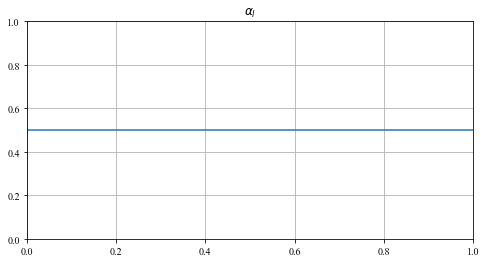

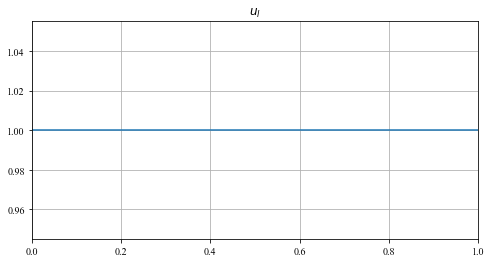

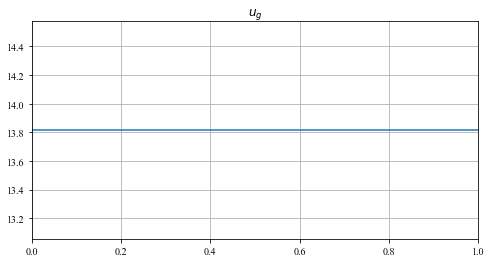

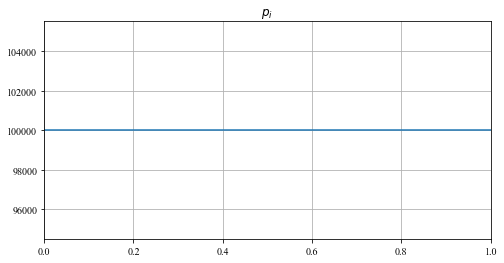

In [3]:
# Define initial conditions
class InitialConditions_SS (UserExpression):
    def eval(self, values, x):
        values[0] = u_ref[0]#var1_ref
        values[1] = u_ref[1]#var2_ref
        values[2] = u_ref[2]#var3_ref
        values[3] = u_ref[3]#var4_ref
    def value_shape(self):
        return (4,)

# class InitialConditions_SS1 (UserExpression):
#     def eval(self, values, x):
#         values[0] = ref[0]
#     def value_shape(self):
#         return (1,)
# class InitialConditions_SS2 (UserExpression):
#     def eval(self, values, x):
#         values[0] = ref[1]
#     def value_shape(self):
#         return (1,)
# class InitialConditions_SS3 (UserExpression):
#     def eval(self, values, x):
#         values[0] = ref[2]
#     def value_shape(self):
#         return (1,)
# class InitialConditions_SS4 (UserExpression):
#     def eval(self, values, x):
#         values[0] = ref[3]
#     def value_shape(self):
#         return (1,)

class InitialConditions_SS_perturbed (UserExpression):
    def eval(self, values, x):
        amplitude1 = (eigenvector[0]).real
        amplitude2 = (eigenvector[1]).real
        amplitude3 = (eigenvector[2]).real
        amplitude4 = (eigenvector[3]).real
        values[0] = ref[0] + amplitude1*cos (-k*x[0]) 
        values[1] = ref[1] + amplitude2*cos (-k*x[0]) 
        values[2] = ref[2] + amplitude3*cos (-k*x[0]) 
        values[3] = ref[3] + amplitude4*cos (-k*x[0]) 
    def value_shape(self):
        return (4,)

# Dirichlet boundary condition
def right (x, on_boundary): 
    return x[0] > (l - DOLFIN_EPS)
def left (x, on_boundary): 
    return x[0] < DOLFIN_EPS
    
# Periodic boundary condition
class PeriodicBoundary(SubDomain):
    # Left boundary is "target domain" G
    def inside(self, x, on_boundary):
          return bool(x[0] < DOLFIN_EPS and x[0] > - DOLFIN_EPS and on_boundary)
    # Map right boundary (H) to left boundary (G)
    def map(self, x, y):
          y[0] = x[0] - l
          print("x = ", x)   

# Class for interfacing with the Newton solver (with BC)
class TwoFluidModelEquations(NonlinearProblem):
    def __init__(self, a, L, bcs, form_compiler_parameters):
        NonlinearProblem.__init__(self)
        self.L = L
        self.a = a
        self.bcs = bcs
    def F (self, b, x):
        assemble (self.L, tensor = b)
        for bc in bcs:
            bc.apply (b, x)
    def J (self, A, x):
        assemble (self.a, tensor = A)
        for bc in bcs:
            bc.apply (A)

if simulation == 'linear_stability':
    # Define time discretization properties
    if base_CFL == 'liquid':
        u_CFL = var2_ref
    elif base_CFL == 'gas':
        u_CFL = var3_ref
    elif base_CFL == 'max_velocity':
        u_CFL = max (var2_ref, var3_ref)

    deltax = l/nx

    if timestep == "timestep_input":
        dt = dt_input
    elif timestep == "cfl_based":
        dt = CFL*deltax/(u_CFL)                  # Van Zwieten & Smith /lambda_max Holmas (maximum modulus of the eigenvalues of the Jacobian of (4.1) at time 

    if T_simulation == "T_input":     # OPTIONS: T_cfl_based, T_input
        T = T_in
        num_steps = round(T/dt)
    elif T_simulation == "T_cfl_based":
        T = num_steps*dt

    print("INFO: T     = ", T)
    print("INFO: dt    = ", dt)
    print("INFO: steps = ", num_steps)
elif simulation == 'stiffness':
    pass

# Define constants
Length = Constant(l)

# Define space discretization properties
xmin = 0
xmax = Length
mesh = IntervalMesh (nx, xmin, xmax)
coordinates = mesh.coordinates();

# Define function space
element1 = FiniteElement ('Lagrange', mesh.ufl_cell (), degree = p - 1)
element2 = FiniteElement ('Lagrange', mesh.ufl_cell (), degree = p - 1)
element3 = FiniteElement ('Lagrange', mesh.ufl_cell (), degree = p)
element4 = FiniteElement ('Lagrange', mesh.ufl_cell (), degree = p)

element = MixedElement ([element1, element2, element3, element4])

if dirichlet_type == "nonperiodic":
    V = FunctionSpace (mesh, element)
    # dofmap = V.dofmap()
    # dofs = dofmap.dofs()
    # print("INFO: degrees of freedom :", len(dofs))
    # dofmapvar1 = V.sub(0).dofmap()
    # dofsvar1 = dofmapvar1.dofs()
    # print("INFO: degrees of freedom subspace 1:", len(dofsvar1))
    # dofmapvar2 = V.sub(1).dofmap()
    # dofsvar2 = dofmapvar2.dofs()
    # print("INFO: degrees of freedom subspace 2:", len(dofsvar2))
    # dofmapvar3 = V.sub(2).dofmap()
    # dofsvar3 = dofmapvar3.dofs()
    # print("INFO: degrees of freedom subspace 3:", len(dofsvar3))
    # dofmapvar4 = V.sub(3).dofmap()
    # dofsvar4 = dofmapvar4.dofs()
    # print("INFO: degrees of freedom subspace 4:", len(dofsvar4))
elif dirichlet_type == "periodic":
    pbc = PeriodicBoundary()
    V = FunctionSpace (mesh, element, constrained_domain = pbc)    

if simulation == 'linear_stability':
    # Define variational problem
    du = TrialFunction (V)
    v1, v2, v3, v4 = TestFunctions (V)

    # Collapse mixed function space
    # V_var1 = V.sub(0).collapse()
    # V_var2 = V.sub(1).collapse()
    # V_var3 = V.sub(2).collapse()
    # V_var4 = V.sub(3).collapse()

    # # # Define functions
    # var1_0 = Function (V_var1)
    # var2_0 = Function (V_var2)
    # var3_0 = Function (V_var3)
    # var4_0 = Function (V_var4)

    u = Function (V) # solution from (n+1) current step
    u_n = Function (V) # solution from (n) previous converged step
    u_past = Function (V) # solution from (n-1) previous converged step
    u_ic = Function (V) # reference solution from initial conditions

    # Split mixed functions
    du1, du2, du3, du4 = split (du)

    u1, u2, u3, u4 = split (u)
    u1_n, u2_n, u3_n, u4_n = split (u_n)
    u1_past, u2_past, u3_past, u4_past = split (u_past)
    u1_ic, u2_ic, u3_ic, u4_ic = split (u_ic)

elif simulation == 'stiffness':
    # Define variational problem
    # dvar = TrialFunction (V)
    var = TrialFunction (V)
    v1, v2, v3, v4 = TestFunctions (V)
    # Define functions
    var_0 = Function (V)
    # var = Function (V)   
    # Split mixed functions
    # dvar1, dvar2, dvar3, dvar4 = split (dvar)
    var1_0, var2_0, var3_0, var4_0 = split (var_0)
    var1, var2, var3, var4 = split (var)

if IBVP == 'SS':
    u1_dirichlet = Constant (u1_ref/rho_l) 
    u2_dirichlet = Constant (u3_ref/u1_ref)
    u3_dirichlet = Constant (u4_ref/u2_ref) 
    u4_dirichlet = Constant (p_0 + c_g**2*(-rho_g_0 +rho_l*u2_ref/u1_ref)) 
elif IBVP == 'SS_perturbed':
    timedirichlet = 0
    amplitude1 = (eigenvector[0]).real
    amplitude2 = (eigenvector[1]).real
    amplitude3 = (eigenvector[2]).real
    amplitude4 = (eigenvector[3]).real
    var1_dirichlet = Expression('var1_ref + amplitude1*sin (ang_frequency*timedirichlet - k*x[0])', degree = p - 1, var1_ref = var1_ref, amplitude1 = amplitude1, k = k, ang_frequency = ang_frequency, timedirichlet = timedirichlet, domain = mesh)
    var2_dirichlet = Expression('var2_ref + amplitude2*sin (ang_frequency*timedirichlet - k*x[0])', degree = p, var2_ref = var2_ref, amplitude2 = amplitude2, k = k, ang_frequency = ang_frequency, timedirichlet = timedirichlet, domain = mesh)
    var3_dirichlet = Expression('var3_ref + amplitude3*sin (ang_frequency*timedirichlet - k*x[0])', degree = p, var3_ref = var3_ref, amplitude3 = amplitude3, k = k, ang_frequency = ang_frequency, timedirichlet = timedirichlet, domain = mesh)
    var4_dirichlet = Expression('var4_ref + amplitude4*sin (ang_frequency*timedirichlet - k*x[0])', degree = p - 1, var4_ref = var4_ref, amplitude4 = amplitude4, k = k, ang_frequency = ang_frequency, timedirichlet = timedirichlet, domain = mesh)

# bc1 = DirichletBC (V.sub (0).collapse(), var1_dirichlet, left, "pointwise")
# bc2 = DirichletBC (V.sub (1).collapse(), var2_dirichlet, left, "pointwise")
# bc3 = DirichletBC (V.sub (2).collapse(), var3_dirichlet, left, "pointwise")
# bc4 = DirichletBC (V.sub (3).collapse(), var4_dirichlet, right, "pointwise")

bc1 = DirichletBC (V.sub (0), u1_dirichlet, left, "pointwise")
bc2 = DirichletBC (V.sub (1), u2_dirichlet, left, "pointwise")
bc3 = DirichletBC (V.sub (2), u3_dirichlet, left, "pointwise")
bc4 = DirichletBC (V.sub (3), u4_dirichlet, right, "pointwise")
bcs = [bc1, bc2, bc3, bc4]

# Create intial conditions and interpolate
# if simulation == 'linear_stability':
#     # Interpolation
#     if IBVP == 'SS':
#         var1_0.interpolate(Constant(var1_ref))
#         var2_0.interpolate(Constant(var2_ref))
#         var3_0.interpolate(Constant(var3_ref))
#         var4_0.interpolate(Constant(var4_ref))
#     elif IBVP == 'SS_perturbed':
#         var1_0.interpolate(Expression("var1_ref + amplitude1*cos (-k*x[0])", degree = p - 1, var1_ref = var1_ref, amplitude1 = amplitude1, k = k, domain = mesh))
#         var2_0.interpolate(Expression("var2_ref + amplitude2*cos (-k*x[0])", degree = p, var2_ref = var2_ref, amplitude2 = amplitude2, k = k, domain = mesh ))
#         var3_0.interpolate(Expression("var3_ref + amplitude3*cos (-k*x[0])", degree = p, var3_ref = var3_ref, amplitude3 = amplitude3, k = k, domain = mesh ))
#         var4_0.interpolate(Expression("var4_ref + amplitude4*cos (-k*x[0])", degree = p - 1, var4_ref = var4_ref, amplitude4 = amplitude4, k = k, domain = mesh ))

if IBVP == 'SS':
    u_init = InitialConditions_SS ()
    # u1_init = InitialConditions_SS1 (degree = p)
    # u2_init = InitialConditions_SS2 (degree = p - 1)
    # u3_init = InitialConditions_SS3 (degree = p - 1)
    # u4_init = InitialConditions_SS4 (degree = p)
elif IBVP == 'SS_perturbed':
    var_init = InitialConditions_SS_perturbed ()

if simulation == 'linear_stability':
    # var.interpolate (var_init)
    u_n.interpolate (u_init)
    u_ic.interpolate (u_init)

    # var1.interpolate (u1_init)
    # var2.interpolate (u2_init)
    # var3.interpolate (u3_init)
    # var4.interpolate (u4_init)
    
    # var1_0.interpolate (u1_init)
    # var2_0.interpolate (u2_init)
    # var3_0.interpolate (u3_init)
    # var4_0.interpolate (u4_init)

    # var1_0.interpolate(Constant(var1_ref))
    # var2_0.interpolate(Constant(var2_ref))
    # var3_0.interpolate(Constant(var3_ref))
    # var4_0.interpolate(Constant(var4_ref))

    #T heta-method (n+theta)
    # var1_mid = (1.0 - theta)*var1_n + theta*var1
    # var2_mid = (1.0 - theta)*var2_n + theta*var2
    # var3_mid = (1.0 - theta)*var3_n + theta*var3
    # var4_mid = (1.0 - theta)*var4_n + theta*var4
elif simulation == 'stiffness':
    var_ic.interpolate (u_init)

# Plot initial conditions
# fig, ax = plt.subplots ()
plt.figure (1, figsize = (8, 4))
plt.ylim (( 0, 1))
plt.xlim (( 0, l))
plt.grid (True, which = "both")
# ax.set_xlabel(r'L [m]', fontsize = 18)
# ax.set_ylabel(r'$\alpha_l$ [-]', fontsize = 18)
# ax.xaxis.set_tick_params(which='major', size=10, direction='in', top='on')
# ax.xaxis.set_tick_params(which='minor', size=7, direction='in', top='on')
# ax.yaxis.set_tick_params(which='major', size=10, direction='in', right='on')
# ax.yaxis.set_tick_params(which='minor', size=7, direction='in', right='on')
plot (u1_ic/rho_l, title = r"$\alpha_{l}$")

# fig, ax = plt.subplots ()
plt.figure (2, figsize = (8, 4))
plt.xlim (( 0, l))
plt.grid (True, which = "both")
# ax.set_xlabel(r'L [m]', fontsize = 18)
# ax.set_ylabel(r'$u_l$ [m/s]', fontsize = 18)
# ax.xaxis.set_tick_params(which='major', size=10, direction='in', top='on')
# ax.xaxis.set_tick_params(which='minor', size=7, direction='in', top='on')
# ax.yaxis.set_tick_params(which='major', size=10, direction='in', right='on')
# ax.yaxis.set_tick_params(which='minor', size=7, direction='in', right='on')
plot (u3_ic/u1_ic, title = r"$u_{l}$")

# fig, ax = plt.subplots ()
plt.figure (3, figsize = (8, 4))
plt.xlim (( 0, l))
plt.grid (True, which = "both")
# ax.set_xlabel(r'L [m]', fontsize = 18)
# ax.set_ylabel(r'$u_g$ [m/s]', fontsize = 18)
# ax.xaxis.set_tick_params(which='major', size=10, direction='in', top='on')
# ax.xaxis.set_tick_params(which='minor', size=7, direction='in', top='on')
# ax.yaxis.set_tick_params(which='major', size=10, direction='in', right='on')
# ax.yaxis.set_tick_params(which='minor', size=7, direction='in', right='on')
plot (u4_ic/u2_ic, title = r"$u_{g}$")

# fig, ax = plt.subplots ()
plt.figure (4, figsize = (8, 4))
plt.xlim (( 0, l))
plt.grid (True, which = "both")
# ax.set_xlabel(r'L [m]', fontsize = 18)
# ax.set_ylabel(r'$p_i$ [Pa]', fontsize = 18)
# ax.xaxis.set_tick_params(which='major', size=10, direction='in', top='on')
# ax.xaxis.set_tick_params(which='minor', size=7, direction='in', top='on')
# ax.yaxis.set_tick_params(which='major', size=10, direction='in', right='on')
# ax.yaxis.set_tick_params(which='minor', size=7, direction='in', right='on')
plot (p_0 + c_g**2*(-rho_g_0 + rho_l*u2_ic/u1_ic), title = r"$p_{i}$")

# Define constants, expressions and functions used in weak form
# A = Constant (A)
# g = Constant (g)
# D = Constant (D)
# rho_l = Constant (rho_l)
# deltat = Constant(dt)
# theta = Constant (theta)
# if inclination == 'horizontal':
#     beta = Constant (beta)
# elif inclination == 'upward_straight':
#     beta = Constant (beta)
# elif inclination == 'downward_straight':
#     beta = Constant (beta)

In [4]:
# Define terms of variational form
# Amat
def A11 (u1 ,u2, u3, u4):
    return 1
def A12 (u1 ,u2, u3, u4):
    return 0
def A13 (u1 ,u2, u3, u4):
    return 0
def A14 (u1 ,u2, u3, u4):
    return 0

def A21 (u1 ,u2, u3, u4):
    return 0
def A22 (u1 ,u2, u3, u4):
    return 1
def A23 (u1 ,u2, u3, u4):
    return 0
def A24 (u1 ,u2, u3, u4):
    return 0
         
def A31 (u1 ,u2, u3, u4):
    return 0
def A32 (u1 ,u2, u3, u4):
    return 0
def A33 (u1 ,u2, u3, u4):
    return 1
def A34 (u1 ,u2, u3, u4):
    return 0
         
def A41 (u1 ,u2, u3, u4):
    return 0
def A42 (u1 ,u2, u3, u4):
    return 0
def A43 (u1 ,u2, u3, u4):
    return 0
def A44 (u1 ,u2, u3, u4):
    return 1

# Bmat
def B11 (u1 ,u2, u3, u4):
    return u3/u1
def B12 (u1 ,u2, u3, u4):
    return 0
def B13 (u1 ,u2, u3, u4):
    return 0
def B14 (u1 ,u2, u3, u4):
    return 0

def B21 (u1 ,u2, u3, u4):
    return rho_l*u3*u4/pow (u1, 3)
def B22 (u1 ,u2, u3, u4):
    return 0
def B23 (u1 ,u2, u3, u4):
    return (rho_l - u1)*u2/pow (u1, 2)
def B24 (u1 ,u2, u3, u4):
    return 0

def B31 (u1 ,u2, u3, u4):
    return 0
def B32 (u1 ,u2, u3, u4):
    return 2*u1*u3*u4/((-rho_l + u1)*pow (u2, 2))
def B33 (u1 ,u2, u3, u4):
    return 0
def B34 (u1 ,u2, u3, u4):
    return pow (u1, 2)/(pow (rho_l, 2)*u2 - rho_l*u1*u2)

def B41 (u1 ,u2, u3, u4):
    return rho_l*(-rho_l*pow (u4, 2) + g*(-rho_l + u1)*pow (u2, 2)*Dc_fenics (u1))/((rho_l - u1)*pow (u1, 2))
def B42 (u1 ,u2, u3, u4):
    return 0
def B43 (u1 ,u2, u3, u4):
    return 0
def B44 (u1 ,u2, u3, u4):
    return 0

# # Cmat
# C31_ref = Constant (Cmat_lin (var1_ref, var2_ref, var3_ref, var4_ref)[2][0])
# C32_ref = Constant (Cmat_lin (var1_ref, var2_ref, var3_ref, var4_ref)[2][1])
# C33_ref = Constant (Cmat_lin (var1_ref, var2_ref, var3_ref, var4_ref)[2][2])
# C34_ref = Constant (Cmat_lin (var1_ref, var2_ref, var3_ref, var4_ref)[2][3])

# C41_ref = Constant (Cmat_lin (var1_ref, var2_ref, var3_ref, var4_ref)[3][0])
# C42_ref = Constant (Cmat_lin (var1_ref, var2_ref, var3_ref, var4_ref)[3][1])
# C43_ref = Constant (Cmat_lin (var1_ref, var2_ref, var3_ref, var4_ref)[3][2])
# C44_ref = Constant (Cmat_lin (var1_ref, var2_ref, var3_ref, var4_ref)[3][3])

# # Cmat_lin
# def C31 (var1 ,var2, var3, var4):
#     return C31_ref*var1
# def C32 (var1 ,var2, var3, var4):
#     return C32_ref*var2
# def C33 (var1 ,var2, var3, var4):
#     return C33_ref*var3
# def C34 (var1 ,var2, var3, var4):
#     return C34_ref*var4

# def C41 (var1 ,var2, var3, var4):
#     return C41_ref*var1
# def C42 (var1 ,var2, var3, var4):
#     return C42_ref*var2
# def C43 (var1 ,var2, var3, var4):
#     return C43_ref*var3
# def C44 (var1 ,var2, var3, var4):
#     return C44_ref*var4

In [5]:
if simulation == 'linear_stability':
        # Weak statement of the transient linear equations
        # if nonlineartreatment == 'Cahn_Hilliard':
        # Amat
        Am = ( (a0*u1 + a1*u1_n + a2*u1_past)/dt*v1 + (a0*u2 + a1*u2_n + a2*u2_past)/dt*v2 + (a0*u3 + a1*u3_n + a2*u3_past)/dt*v3 + (a0*u4 + a1*u4_n + a2*u4_past)/dt*v4 )*dx 

        # Bmat
        Bm1 = ( inner (B11 (u1_ref, u2_ref, u3_ref, u4_ref)*Dx (u1, 0), v1) \
                + inner (B12 (u1_ref, u2_ref, u3_ref, u4_ref)*Dx (u2, 0), v1) \
                + inner (B13 (u1_ref, u2_ref, u3_ref, u4_ref)*Dx (u3, 0), v1) \
                + inner (B14 (u1_ref, u2_ref, u3_ref, u4_ref)*Dx (u4, 0), v1) )*dx 

        Bm2 = ( inner (B21 (u1_ref, u2_ref, u3_ref, u4_ref)*Dx (u1, 0), v2) \
                + inner (B22 (u1_ref, u2_ref, u3_ref, u4_ref)*Dx (u2, 0), v2) \
                + inner (B23 (u1_ref, u2_ref, u3_ref, u4_ref)*Dx (u3, 0), v2) \
                + inner (B24 (u1_ref, u2_ref, u3_ref, u4_ref)*Dx (u4, 0), v2) )*dx 

        Bm3 = ( inner (B31 (u1_ref, u2_ref, u3_ref, u4_ref)*Dx (u1, 0), v3) \
                + inner (B32 (u1_ref, u2_ref, u3_ref, u4_ref)*Dx (u2, 0), v3) \
                + inner (B33 (u1_ref, u2_ref, u3_ref, u4_ref)*Dx (u3, 0), v3) \
                + inner (B34 (u1, u2, u3, u4)*Dx (u4, 0), v3) )*dx 

        Bm4 = ( inner (B41 (u1_ref, u2_ref, u3_ref, u4_ref)*Dx (u1, 0), v4) \
                + inner (B42 (u1_ref, u2_ref, u3_ref, u4_ref)*Dx (u2, 0), v4) \
                + inner (B43 (u1_ref, u2_ref, u3_ref, u4_ref)*Dx (u3, 0), v4) \
                + inner (B44 (u1_ref, u2_ref, u3_ref, u4_ref)*Dx (u4, 0), v4) )*dx 
        # Cmat
        # Cm3 = ( inner (C31 (var1_mid, var2_mid, var3_mid, var4_mid), v3) \
        #         + inner (C32 (var1_mid, var2_mid, var3_mid, var4_mid), v3) \
        #         + inner (C33 (var1_mid, var2_mid, var3_mid, var4_mid), v3) \
        #         + inner (C34 (var1_mid, var2_mid, var3_mid, var4_mid), v3) )*dx

        # Cm4 = ( inner (C41 (var1_mid, var2_mid, var3_mid, var4_mid),v4) \
        #         + inner (C42 (var1_mid, var2_mid, var3_mid, var4_mid),v4) \
        #         + inner (C43 (var1_mid, var2_mid, var3_mid, var4_mid),v4) \
        #         + inner (C44 (var1_mid, var2_mid, var3_mid, var4_mid),v4) )*dx

        # Bmat_n
        Bm1_n = ( inner (B11 (u1_ref, u2_ref, u3_ref, u4_ref)*Dx (u1_n, 0), v1) \
                + inner (B12 (u1_ref, u2_ref, u3_ref, u4_ref)*Dx (u2_n, 0), v1) \
                + inner (B13 (u1_ref, u2_ref, u3_ref, u4_ref)*Dx (u3_n, 0), v1) \
                + inner (B14 (u1_ref, u2_ref, u3_ref, u4_ref)*Dx (u4_n, 0), v1) )*dx 

        Bm2_n = ( inner (B21 (u1_ref, u2_ref, u3_ref, u4_ref)*Dx (u1_n, 0), v2) \
                + inner (B22 (u1_ref, u2_ref, u3_ref, u4_ref)*Dx (u2_n, 0), v2) \
                + inner (B23 (u1_ref, u2_ref, u3_ref, u4_ref)*Dx (u3_n, 0), v2) \
                + inner (B24 (u1_ref, u2_ref, u3_ref, u4_ref)*Dx (u4_n, 0), v2) )*dx 

        Bm3_n = ( inner (B31 (u1_ref, u2_ref, u3_ref, u4_ref)*Dx (u1_n, 0), v3) \
                + inner (B32 (u1_ref, u2_ref, u3_ref, u4_ref)*Dx (u2_n, 0), v3) \
                + inner (B33 (u1_ref, u2_ref, u3_ref, u4_ref)*Dx (u3_n, 0), v3) \
                + inner (B34 (u1_ref, u2_ref, u3_ref, u4_ref)*Dx (u4_n, 0), v3) )*dx 

        Bm4_n = ( inner (B41 (u1_ref, u2_ref, u3_ref, u4_ref)*Dx (u1_n, 0), v4) \
                + inner (B42 (u1_ref, u2_ref, u3_ref, u4_ref)*Dx (u2_n, 0), v4) \
                + inner (B43 (u1_ref, u2_ref, u3_ref, u4_ref)*Dx (u3_n, 0), v4) \
                + inner (B44 (u1_ref, u2_ref, u3_ref, u4_ref)*Dx (u4_n, 0), v4) )*dx 

        # elif nonlineartreatment == 'regular'

elif simulation == 'stiffness':
        # Weak statement of the stiffness analysis
        # Bmat
        Bm1_stiffness = ( inner (B11 (var1_ref, var2_ref, var3_ref, var4_ref)*Dx (var1, 0), v1) \
                + inner (B12 (var1_ref, var2_ref, var3_ref, var4_ref)*Dx (var2, 0), v1) \
                + inner (B13 (var1_ref, var2_ref, var3_ref, var4_ref)*Dx (var3, 0), v1) \
                + inner (B14 (var1_ref, var2_ref, var3_ref, var4_ref)*Dx (var4, 0), v1) )*dx 

        Bm2_stiffness = ( inner (B21 (var1_ref, var2_ref, var3_ref, var4_ref)*Dx (var1, 0), v2) \
                + inner (B22 (var1_ref, var2_ref, var3_ref, var4_ref)*Dx (var2, 0), v2) \
                + inner (B23 (var1_ref, var2_ref, var3_ref, var4_ref)*Dx (var3, 0), v2) \
                + inner (B24 (var1_ref, var2_ref, var3_ref, var4_ref)*Dx (var4, 0), v2) )*dx 

        Bm3_stiffness = ( inner (B31 (var1_ref, var2_ref, var3_ref, var4_ref)*Dx (var1, 0), v3) \
                + inner (B32 (var1_ref, var2_ref, var3_ref, var4_ref)*Dx (var2, 0), v3) \
                + inner (B33 (var1_ref, var2_ref, var3_ref, var4_ref)*Dx (var3, 0), v3) \
                + inner (B34 (var1_ref, var2_ref, var3_ref, var4_ref)*Dx (var4, 0), v3) )*dx 

        Bm4_stiffness = ( inner (B41 (var1_ref, var2_ref, var3_ref, var4_ref)*Dx (var1, 0), v4) \
                + inner (B42 (var1_ref, var2_ref, var3_ref, var4_ref)*Dx (var2, 0), v4) \
                + inner (B43 (var1_ref, var2_ref, var3_ref, var4_ref)*Dx (var3, 0), v4) \
                + inner (B44 (var1_ref, var2_ref, var3_ref, var4_ref)*Dx (var4, 0), v4) )*dx 
        # Cmat
        # Cm3_stiffness = ( inner (Cmat3_fenics (var1, var2, var3, var4), v3))*dx
        # Cm4_stiffness = ( inner (Cmat4_fenics (var1, var2, var3, var4), v4))*dx

        # Cmat
        Cm3_stiffness = ( inner (C31 (var1, var2, var3, var4), v3) \
                + inner (C32 (var1, var2, var3, var4), v3) \
                + inner (C33 (var1, var2, var3, var4), v3) \
                + inner (C34 (var1, var2, var3, var4), v3) )*dx

        Cm4_stiffness = ( inner (C41 (var1, var2, var3, var4),v4) \
                + inner (C42 (var1, var2, var3, var4),v4) \
                + inner (C43 (var1, var2, var3, var4),v4) \
                + inner (C44 (var1, var2, var3, var4),v4) )*dx


In [6]:
if simulation == 'linear_stability':
    # linear form
    # if nonlineartreatment == 'CahnHilliard':
    # L = Am - theta*(Bm1 + Bm2 + Bm3 + Bm4 - visc*Cm3 - visc*Cm4) - (1-theta)*(Bm1_n + Bm2_n + Bm3_n + Bm4_n - visc*Cm3_n - visc*Cm4_n)
    L = Am - theta*(Bm1 + Bm2 + Bm3 + Bm4) - (1-theta)*(Bm1_n + Bm2_n + Bm3_n + Bm4_n)

    # elif nonlineartreatment == 'regular'

    # Compute directional derivative about u in the direction of du (Jacobian)
    a = derivative (L, u, du)

    # Define the transient problem
    problem = TwoFluidModelEquations(a, L, bcs, form_compiler_parameters = ffc_options)

    solver = NewtonSolver ()
    prm = solver.parameters    
    info (prm, True)

    # prm ['convergence_criterion'] = 'residual'
    # prm ['error_on_nonconvergence'] = True
    prm ['linear_solver'] = 'umfpack'                               #'ml_amg' bicgstab gmres
    # prm ['maximum_iterations'] = 1000
    # # prm ['preconditioner'] = 'ilu'
    # prm ['relative_tolerance'] = 8e-3
    # prm ["absolute_tolerance"] = 8e-5
    # # prm ['relaxation_parameter'] = 0.6
    # prm ['report'] = True

    # prm ['krylov_solver']['absolute_tolerance'] = 1E-5            #1E-9
    # prm ['krylov_solver']['error_on_nonconvergence'] = True
    # prm ['krylov_solver']['maximum_iterations'] = 500000          # 500000
    # prm ['krylov_solver']["monitor_convergence"] = True
    # prm ['krylov_solver']["nonzero_initial_guess"] = True         #False
    # prm ['krylov_solver']['relative_tolerance']= 1E-3
    # prm ['krylov_solver']['report'] = True
        
    # prm ['lu_solver']['report'] = True
    # prm ['lu_solver']['symmetric'] = False
    # prm ['lu_solver']['verbose'] = True

    set_log_level (20)

    # Output file
    ff_w1 = File ("c_tfm_v11/w1.pvd", "compressed")
    ff_w2 = File ("c_tfm_v11/w2.pvd", "compressed")
    ff_w3 = File ("c_tfm_v11/w3.pvd", "compressed")
    ff_w4 = File ("c_tfm_v11/w4.pvd", "compressed")

    # Step in time
    t = 0
    while (t < T):
        # Condition for Dirichlet boundary conditions
        # if IBVP == 'SS_perturbed':
        #     var1_dirichlet.timedirichlet = t
        #     var2_dirichlet.timedirichlet = t
        #     var3_dirichlet.timedirichlet = t
        #     var4_dirichlet.timedirichlet = t
        # else:
        #     pass

        if t == 0:
            (u1_n, u2_n, u3_n, u4_n) = u_n.split (deepcopy = True)

            # Compute  nodal values (initial)
            n_val1_n = np.array (u1_n.vector ())
            n_val2_n = np.array (u2_n.vector ())
            n_val3_n = np.array (u3_n.vector ())
            n_val4_n = np.array (u4_n.vector ())

            nodal_u1_n = n_val1_n [::-1]
            nodal_u2_n = n_val2_n [::-1]
            nodal_u3_n = n_val3_n [::-1]
            nodal_u4_n = n_val4_n [::-1]

            # print("n", nodal_var1_n)

            nodes_u1_n = len (nodal_u1_n)
            nodes_u2_n = len (nodal_u2_n)
            nodes_u3_n = len (nodal_u3_n)
            nodes_u4_n = len (nodal_u4_n)

            print ("dof subspace u1 =", nodes_u1_n)
            print ("dof subspace u2 =", nodes_u2_n)
            print ("dof subspace u3 =", nodes_u3_n)
            print ("dof subspace u4 =", nodes_u4_n)

            # Compute vertex values (initial step)
            v_u1_n = u1_n.compute_vertex_values (mesh)
            v_u2_n = u2_n.compute_vertex_values (mesh)
            v_u3_n = u3_n.compute_vertex_values (mesh)
            v_u4_n = u4_n.compute_vertex_values (mesh)

            vert_u1_n = []
            vert_u2_n = []
            vert_u3_n = []
            vert_u4_n = []

            for cond_vert in range (len(coordinates)):
                    vert_u1_n.append (v_u1_n[cond_vert])
                    vert_u2_n.append (v_u2_n[cond_vert])
                    vert_u3_n.append (v_u3_n[cond_vert])
                    vert_u4_n.append (v_u4_n[cond_vert])
            
            vert_u1_n = np.asarray (vert_u1_n)
            vert_u2_n = np.asarray (vert_u2_n)
            vert_u3_n = np.asarray (vert_u3_n)
            vert_u4_n = np.asarray (vert_u4_n)

            print("u1_n = ", vert_u1_n)

            data_w1_n = vert_u1_n/rho_l
            data_w2_n = vert_u3_n/vert_u1_n
            data_w3_n = vert_u4_n/vert_u2_n
            data_w4_n = p_0 + c_g**2*(-rho_g_0 + rho_l*vert_u2_n/vert_u1_n)

            print("w1_n = ", data_w1_n)

            # Well-posedness check
            i = 0
            for w1_test_n, w2_test_n, w3_test_n, w4_test_n in zip (data_w1_n, data_w2_n, data_w3_n, data_w4_n):
                Aeval = np.asarray (Amat (w1_test_n, w2_test_n, w3_test_n, w4_test_n))
                Beval = np.asarray (Bmat (w1_test_n, w2_test_n, w3_test_n, w4_test_n))

                m_test, v1 = eig (Beval, b = Aeval)
                length1 = len (m_test)

                listreal = []
                listimag = []

                for cond0 in range (length1):
                    realpart = m_test [cond0].real                
                    imagpart = m_test [cond0].imag
                    
                    listimag.append (imagpart)
                    listreal.append (realpart)
                
                if any ([ cond1 != 0 for cond1 in listimag ]) :
                    print("INFO: ill-posed equation system")
                    break
                else: 
                    i += 1
                break

            # Condition for low liquid level of transition to intermittent flow
            if any ([cond2 <= 0 for cond2 in data_w1_n]) :
                print("INFO: gas phase dominant. Low liquid level. Liquid equations vanish")
                break
            elif any ([cond2 >= 1 for cond2 in data_w1_n]):
                print("INFO: liquid phase dominant. Intermittent flow. Gas equations vanish")
                break
            else:
                pass
            # Condition for positive velocities and pressure
            if any ([ cond3 <= 0 for cond3 in data_w2_n]) :
                print("INFO: negative liquid velocity")
                break
            else:
                pass

            if any ([ cond4 <= 0 for cond4 in data_w3_n]) :
                print("INFO: negative gas velocity")
                break
            else:
                pass

            if any ([ cond5 <= 0 for cond5 in data_w4_n]) :
                print("INFO: negative pressure")
                break
            else:
                pass
            
            # Reynolds check
            Rel_n = Re_l (data_w1_n, data_w2_n)
            Reg_n = Re_g (data_w1_n, data_w3_n, data_w4_n)
            # Regl = Re_gl (vert_var1_n, vert_var2_n, vert_var3_n, vert_var4_n)

            if any ([ cond4 <= 1180 for cond4 in Rel_n]):
            # Rel < 1180:
                print("Liquid laminar")
            elif  any ([ cond4 > 1180 for cond4 in Rel_n]):
                pass

            if any ([ cond5 <= 1180 for cond5 in Reg_n]):
                print("Gas laminar")
            elif  any ([ cond4 > 1180 for cond4 in Reg_n]):
                pass

            # c = conditional (ge (var1, 1), 2, info(var1, verbose=False))
            # c = conditional (le (var1, 0), str(INFO: liquid phase dominant, which leads to intermittent flow. Gas equations vanish), 1)

            # Plot solution
            # fig, ax = plt.subplots ()
            plt.figure (5, figsize = (8, 4))
            plt.xlim (( 0, l))
            plt.ylim (( 0, 1))
            plt.grid (True, which = "both")
            # ax.set_xlabel(r'L [m]', fontsize = 18)
            # ax.set_ylabel(r'$\alpha_l$ [-]', fontsize = 18)
            # ax.xaxis.set_tick_params(which='major', size=10, direction='in', top='on')
            # ax.xaxis.set_tick_params(which='minor', size=7, direction='in', top='on')
            # ax.yaxis.set_tick_params(which='major', size=10, direction='in', right='on')
            # ax.yaxis.set_tick_params(which='minor', size=7, direction='in', right='on')
            plot (u1_n/rho_l, title = r"$\alpha_l$", rescale = True)

            # fig, ax = plt.subplots ()
            plt.figure (6, figsize = (8, 4))
            plt.xlim (( 0, l))
            plt.grid (True, which = "both")
            # ax.set_xlabel(r'L [m]', fontsize = 18)
            # ax.set_ylabel(r'$u_l$ [m/s]', fontsize = 18)
            # ax.xaxis.set_tick_params(which='major', size=10, direction='in', top='on')
            # ax.xaxis.set_tick_params(which='minor', size=7, direction='in', top='on')
            # ax.yaxis.set_tick_params(which='major', size=10, direction='in', right='on')
            # ax.yaxis.set_tick_params(which='minor', size=7, direction='in', right='on')
            plot (u3_n/u1_n, title = r"$u_l$", rescale = True)

            # fig, ax = plt.subplots ()
            plt.figure (7, figsize = (8, 4))
            plt.xlim (( 0, l))
            plt.grid (True, which = "both")
            # ax.set_xlabel(r'L [m]', fontsize = 18)
            # ax.set_ylabel(r'$u_g$ [m/s]', fontsize = 18)
            # ax.xaxis.set_tick_params(which='major', size=10, direction='in', top='on')
            # ax.xaxis.set_tick_params(which='minor', size=7, direction='in', top='on')
            # ax.yaxis.set_tick_params(which='major', size=10, direction='in', right='on')
            # ax.yaxis.set_tick_params(which='minor', size=7, direction='in', right='on')
            plot (u4_n/u2_n, title = r"$u_g$", rescale = True)

            # fig, ax = plt.subplots ()
            plt.figure (8, figsize = (8, 4))
            plt.xlim (( 0, l))
            plt.grid (True, which = "both")
            # ax.set_xlabel(r'L [m]', fontsize = 18)
            # ax.set_ylabel(r'$p_i$ [Pa]', fontsize = 18)
            # ax.xaxis.set_tick_params(which='major', size=10, direction='in', top='on')
            # ax.xaxis.set_tick_params(which='minor', size=7, direction='in', top='on')
            # ax.yaxis.set_tick_params(which='major', size=10, direction='in', right='on')
            # ax.yaxis.set_tick_params(which='minor', size=7, direction='in', right='on')
            plot (p_0 + c_g**2*(-rho_g_0 + rho_l*u2_n/u1_n), title = r"$p_i$", rescale = True)
            
            W1 = VectorFunctionSpace(mesh, 'P', p-1)
            W2 = VectorFunctionSpace(mesh, 'P', p-1)
            W3 = VectorFunctionSpace(mesh, 'P', p-1)
            W4 = VectorFunctionSpace(mesh, 'P', p-1)

            w1 = Function (W1) # reference solution from initial conditions
            w2 = Function (W2) # reference solution from initial conditions
            w3 = Function (W3) # reference solution from initial conditions
            w4 = Function (W4) # reference solution from initial conditions
            
            w1_n = Function (W1) # reference solution from initial conditions
            w2_n = Function (W2) # reference solution from initial conditions
            w3_n = Function (W3) # reference solution from initial conditions
            w4_n = Function (W4) # reference solution from initial conditions

            # w1_n=u1_n/rho_l
            # w2_n=u3_n/u1_n
            # w3_n=u4_n/u2_n
            # w4_n=p_0 + c_g**2*(-rho_g_0 + rho_l*u2_n/u1_n)

            # ff_w1 << w1_n
            # ff_w2 << w2_n
            # ff_w3 << w3_n
            # ff_w4 << w4_n

            # # Save solution
            # ff_w1 << u1_n/rho_l
            # ff_w2 << u3_n/u1_n
            # ff_w3 << u4_n/u2_n
            # ff_w4 << p_0 + c_g**2*(-rho_g_0 + rho_l*u2_n/u1_n)
            
            # w1_n.vector()[:] = data_w1_n[:]
            # w2_n.vector()[:] = data_w2_n[:]
            # w3_n.vector()[:] = data_w3_n[:]
            # w4_n.vector()[:] = data_w4_n[:]

            # # # Save solution
            # ff_w1 << w1_n
            # ff_w2 << w2_n
            # ff_w3 << w3_n
            # ff_w4 << w4_n

        else:
            pass
        
        # Time stepping
        t += dt # t = t + dt
        
        # Print progress
        clear_output ()
        print ("Iteration :", round (t/dt), "of", num_steps)
        print ("Time      :", t, "s")

        if time_method == 'BDF2':
            if t == dt:
                a2 = 0
            else:
                a2 = 1/2

        # Solution
        solver.solve (problem, u.vector ())
        
        # Split of the vector var
        (u1, u2, u3, u4) = u.split (deepcopy = True)

        # Nodal values (current)
        n_val1_n1 = np.array(u1.vector())
        n_val2_n1 = np.array(u2.vector())
        n_val3_n1 = np.array(u3.vector())
        n_val4_n1 = np.array(u4.vector())

        nodal_u1_n1 = n_val1_n1 [::-1]
        nodal_u2_n1 = n_val2_n1 [::-1]
        nodal_u3_n1 = n_val3_n1 [::-1]
        nodal_u4_n1 = n_val4_n1 [::-1]

        # print("n+1", nodal_var1_n1)

        # Compute vertex values (next step)
        vert_u1 = u1.compute_vertex_values (mesh)
        vert_u2 = u2.compute_vertex_values (mesh)
        vert_u3 = u3.compute_vertex_values (mesh)
        vert_u4 = u4.compute_vertex_values (mesh)

        vert_u1_n1 = []
        vert_u2_n1 = []
        vert_u3_n1 = []
        vert_u4_n1 = []

        for cond_vert in range (len(coordinates)):
                vert_u1_n1.append (vert_u1[cond_vert])
                vert_u2_n1.append (vert_u2[cond_vert])
                vert_u3_n1.append (vert_u3[cond_vert])
                vert_u4_n1.append (vert_u4[cond_vert])
        
        vert_u1_n1 = np.asarray (vert_u1_n1)
        vert_u2_n1 = np.asarray (vert_u2_n1)
        vert_u3_n1 = np.asarray (vert_u3_n1)
        vert_u4_n1 = np.asarray (vert_u4_n1)

        print ("var1_n1 = ", vert_u1_n1)

        data_w1_n1 = vert_u1_n1/rho_l
        data_w2_n1 = vert_u3_n1/vert_u1_n1
        data_w3_n1 = vert_u4_n1/vert_u2_n1
        data_w4_n1 = p_0 + c_g**2*(-rho_g_0 + rho_l*vert_u2_n1/vert_u1_n1)

        # Well-posedness check
        i = 0
        for w1_test_n1, w2_test_n1, w3_test_n1, w4_test_n1 in zip (data_w1_n1, data_w2_n1, data_w3_n1, data_w4_n1):
            Aeval = np.asarray (Amat (w1_test_n1, w2_test_n1, w3_test_n1, w4_test_n1))
            Beval = np.asarray (Bmat (w1_test_n1, w2_test_n1, w3_test_n1, w4_test_n1))

            m_test, v1 = eig (Beval, b = Aeval)
            length1 = len (m_test)

            listreal = []
            listimag = []

            for cond0 in range (length1):
                realpart = m_test [cond0].real                
                imagpart = m_test [cond0].imag
                
                listimag.append (imagpart)
                listreal.append (realpart)
            
            if any ([ cond1 != 0 for cond1 in listimag ]) :
                print("INFO: ill-posed equation system")
                break
            else: 
                i += 1
            break

        # Condition for low liquid level of transition to intermittent flow
        if any ([cond2 <= 0 for cond2 in data_w1_n1]) :
            print("INFO: gas phase dominant. Low liquid level. Liquid equations vanish")
            break
        elif any ([cond2 >= 1 for cond2 in data_w1_n1]):
            print("INFO: liquid phase dominant. Intermittent flow. Gas equations vanish")
            break
        else:
            pass
        # Condition for positive velocities and pressure
        if any ([ cond3 <= 0 for cond3 in data_w2_n1]) :
            print("INFO: negative liquid velocity")
            break
        else:
            pass

        if any ([ cond4 <= 0 for cond4 in data_w3_n1]) :
            print("INFO: negative gas velocity")
            break
        else:
            pass

        if any ([ cond5 <= 0 for cond5 in data_w4_n1]) :
            print("INFO: negative pressure")
            break
        else:
            pass
        
        # Reynolds check
        Rel_n1 = Re_l (vert_u1_n1, vert_u2_n1)
        Reg_n1 = Re_g (vert_u1_n1, vert_u3_n1, vert_u4_n1)
        # Regl = Re_gl (vert_var1_n, vert_var2_n, vert_var3_n, vert_var4_n)

        if any ([ cond4 <= 1180 for cond4 in Rel_n1]):
        # Rel < 1180:
            print("Liquid laminar")
        elif  any ([ cond4 > 1180 for cond4 in Rel_n1]):
            pass

        if any ([ cond5 <= 1180 for cond5 in Reg_n1]):
            print("Gas laminar")
        elif  any ([ cond4 > 1180 for cond4 in Reg_n1]):
            pass

        # c = conditional (ge (var1, 1), 2, info(var1, verbose=False))
        # c = conditional (le (var1, 0), str(INFO: liquid phase dominant, which leads to intermittent flow. Gas equations vanish), 1)

        # Plot solution
        # fig, ax = plt.subplots ()
        plt.figure (5, figsize = (8, 4))
        plt.xlim (( 0, l))
        plt.ylim (( 0, 1))
        plt.grid (True, which = "both")
        # ax.set_xlabel(r'L [m]', fontsize = 18)
        # ax.set_ylabel(r'$\alpha_l$ [-]', fontsize = 18)
        # ax.xaxis.set_tick_params(which='major', size=10, direction='in', top='on')
        # ax.xaxis.set_tick_params(which='minor', size=7, direction='in', top='on')
        # ax.yaxis.set_tick_params(which='major', size=10, direction='in', right='on')
        # ax.yaxis.set_tick_params(which='minor', size=7, direction='in', right='on')
        plot (u1/rho_l, title = r"$\alpha_l$", rescale = True)

        # fig, ax = plt.subplots ()
        plt.figure (6, figsize = (8, 4))
        plt.xlim (( 0, l))
        plt.grid (True, which = "both")
        # ax.set_xlabel(r'L [m]', fontsize = 18)
        # ax.set_ylabel(r'$u_l$ [m/s]', fontsize = 18)
        # ax.xaxis.set_tick_params(which='major', size=10, direction='in', top='on')
        # ax.xaxis.set_tick_params(which='minor', size=7, direction='in', top='on')
        # ax.yaxis.set_tick_params(which='major', size=10, direction='in', right='on')
        # ax.yaxis.set_tick_params(which='minor', size=7, direction='in', right='on')
        plot (u3/u1, title = r"$u_l$", rescale = True)

        # fig, ax = plt.subplots ()
        plt.figure (7, figsize = (8, 4))
        plt.xlim (( 0, l))
        plt.grid (True, which = "both")
        # ax.set_xlabel(r'L [m]', fontsize = 18)
        # ax.set_ylabel(r'$u_g$ [m/s]', fontsize = 18)
        # ax.xaxis.set_tick_params(which='major', size=10, direction='in', top='on')
        # ax.xaxis.set_tick_params(which='minor', size=7, direction='in', top='on')
        # ax.yaxis.set_tick_params(which='major', size=10, direction='in', right='on')
        # ax.yaxis.set_tick_params(which='minor', size=7, direction='in', right='on')
        plot (u4/u2, title = r"$u_g$", rescale = True)

        # fig, ax = plt.subplots ()
        plt.figure (8, figsize = (8, 4))
        plt.xlim (( 0, l))
        plt.grid (True, which = "both")
        # ax.set_xlabel(r'L [m]', fontsize = 18)
        # ax.set_ylabel(r'$p_i$ [Pa]', fontsize = 18)
        # ax.xaxis.set_tick_params(which='major', size=10, direction='in', top='on')
        # ax.xaxis.set_tick_params(which='minor', size=7, direction='in', top='on')
        # ax.yaxis.set_tick_params(which='major', size=10, direction='in', right='on')
        # ax.yaxis.set_tick_params(which='minor', size=7, direction='in', right='on')
        plot (p_0 + c_g**2*(-rho_g_0 + rho_l*u2/u1), title = r"$p_i$", rescale = True)
    
        # # Save solution
        # ff_w1 << project (u1/rho_l, W1)
        # ff_w2 << project (u3/u1, W2)
        # ff_w3 << project (u4/u2, W3)
        # ff_w4 << project (p_0 + c_g**2*(-rho_g_0 + rho_l*u2_n/u1), W4)

        # ff_w1 << data_w1_n1
        # ff_w2 << data_w2_n1
        # ff_w3 << data_w3_n1
        # ff_w4 << data_w4_n1

        # Save solution
        # ff_var1 << u1/rho_l
        # ff_var2 << u3/u1
        # ff_var3 << u4/u2
        # ff_var4 << p_0 + c_g**2*(-rho_g_0 + rho_l*u2/u1)

        # # Compute the amplification factor 
        # G1 = abs (np.divide (vert_u1_n1, vert_u1_n))
        # G2 = abs (np.divide (vert_u2_n1, vert_u2_n))
        # G3 = abs (np.divide (vert_u3_n1, vert_u3_n))
        # G4 = abs (np.divide (vert_u4_n1, vert_u4_n))

        # print ("G1 = ", G1)

        # z1 = (a0*G1**2 + a1*G1 + a2)/(theta*G1**2 + (1 - theta)*G1)
        # z2 = (a0*G2**2 + a1*G2 + a2)/(theta*G2**2 + (1 - theta)*G2)
        # z3 = (a0*G3**2 + a1*G3 + a2)/(theta*G3**2 + (1 - theta)*G3)
        # z4 = (a0*G4**2 + a1*G4 + a2)/(theta*G4**2 + (1 - theta)*G4)

        # print ("z1 = ", z1)

        # mu1 = z1/dt
        # print ("mu1", mu1)
        # mu2 = z2/dt
        # mu3 = z3/dt
        # mu4 = z4/dt

        # mu1_abs = abs (mu1)
        # print ("mu1_abs", mu1_abs)
        # mu2_abs = abs (mu2)
        # mu3_abs = abs (mu3)
        # mu4_abs = abs (mu4)

        # localmax_mu1 = np.where (mu1_abs == mu1_abs.max ())
        # localmax_mu2 = np.where (mu2_abs == mu2_abs.max ())
        # localmax_mu3 = np.where (mu3_abs == mu3_abs.max ())
        # localmax_mu4 = np.where (mu4_abs == mu4_abs.max ())

        # print ("mumax = ", mu1_abs.max ())

        # print (localmax_mu1)
        # print (localmax_mu2)
        # print (localmax_mu3)
        # print (localmax_mu4)

        # print("G1 for  mumax = ", G1[localmax_mu1[0]])
        # numstab = z.real
        # if G 

        if time_method == 'BDF2':
            u_past.vector ()[:] = u_n.vector () 

        u_n.vector ()[:] = u.vector () 

    # Hold plot
    plt.show ()

    # Show time of the program's execution
    start_time  = time.time ()
    if __name__ == '__main__':
        print("Time of the program's execution: %s seconds " % (time.time () - start_time))

####################################################################################
if simulation == 'stiffness':
    L = Bm1_stiffness + Bm2_stiffness + Bm3_stiffness + Bm4_stiffness - visc*Cm3_stiffness - visc*Cm4_stiffness

    var_= Function(V)
    var1_, var2_, var3_, var4_  = split (var_)

    F = action (L, var_)

    dummy = (inner (Constant(0.0), v1) + inner (Constant(0.0), v2) + inner (Constant(0.0), v3) + inner (Constant(0.0), v4))*dx

    dF = derivative (F, var_, var)

    if withBC == "bcs":
        bcs = bcs
    elif withBC == "empty":
        bcs = []
# ###########
    # Assemble stiffness form    
    Amatrix = PETScMatrix()
    bvector = PETScVector()

    assemble_system(dF, dummy, bcs, A_tensor = Amatrix, b_tensor = bvector)

    A_matrix = as_backend_type(Amatrix).mat()
    A_sparray = csr_matrix(A_matrix.getValuesCSR()[::-1], shape = A_matrix.size)
    # print("A_sparray             =", A_sparray)
    
    fig, ax = plt.subplots ()
    plt.spy(A_sparray)
    plt.grid (True, which = "both") 
    plt.rcParams ['figure.figsize'] = [12, 8]
    plt.xlabel (r'Re [$\mu$] [1/s]', fontsize = 18)
    plt.ylabel (r'Im [$\mu$] [1/s]', fontsize = 16)
    Aevaluated = A_sparray.toarray()

    condnumber = LA.cond(Aevaluated)
    print ("Condition number :", condnumber)

    eigensolver = SLEPcEigenSolver (Amatrix)
    prm1 = eigensolver.parameters 
    PETScOptions.set("eps_view")
    prm1["solver"]             = "arnoldi"
    # prm1["problem_type"]       = "non_hermitian"
    # prm1["spectrum"]           = "target magnitude"
    # prm1["spectral_transform"] = "shift-and-invert"
    # prm1["spectral_shift"]     = 0.5
    eigensolver.solve ()
    r, c, rx, cx = eigensolver.get_eigenpair(0)
    print (r)


    #Exporting the real part of the eigenvectors and plotting
    #eigenvalues
    Real = []
    Complex = []

    for i in range(eigensolver.get_number_converged()):
        r, c, rv, cv = eigensolver.get_eigenpair(i)
        var_.vector()[:] = rv

        Real.append(r)
        Complex.append(c)

    # print(Real)
    fig, ax = plt.subplots ()
    area = 25

    ax.scatter (Real, Complex, s = area, marker = listmarkers [0], color = listcolor [4], edgecolors = listcolor [0], linewidths = 1.5, alpha = 0.5)
    ax.set_xscale ('symlog')

    plt.rcParams ['figure.figsize'] = [12, 8]
    # leg1 = ax.legend (loc = 'upper right', frameon = True, fontsize = 14);
    plt.grid (True, which = "both")
    plt.xlabel ('Re $[\omega]$ [1/s]', fontsize = 18)
    plt.ylabel ('Im $[\omega]$ [1/s]', fontsize = 16)
    matplotlib.rc ('xtick', labelsize = 18)     
    matplotlib.rc ('ytick', labelsize = 18)

    print (r)
# ##########
    # Ateste, _ = assemble_system(dF, dummy, bcs)
    # AA = matrix(Ateste.array())
    # # print(AA)
    
    # l1, v = linalg.eig(AA)
    # print("l1 min, max ", min(l1.real), max(l1.real))

    # fig, ax = plt.subplots ()
    # area = 25

    # ax.scatter (l1.real, l1.imag, s = area, marker = listmarkers [0], color = listcolor [4], edgecolors = listcolor [0], linewidths = 1.5, alpha = 0.5)
    # # ax.set_xscale ('symlog')

    # plt.rcParams ['figure.figsize'] = [12, 8]
    # # leg1 = ax.legend (loc = 'upper right', frameon = True, fontsize = 14);
    # plt.grid (True, which = "both")
    # plt.xlabel ('Re $[\omega]$ [1/s]', fontsize = 18)
    # plt.ylabel ('Im $[\omega]$ [1/s]', fontsize = 16)
    # matplotlib.rc ('xtick', labelsize = 18)     
    # matplotlib.rc ('ytick', labelsize = 18)

Iteration : 1.0 of 100
Time      : 0.024999194115719513 s
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


RuntimeError: 

*** -------------------------------------------------------------------------
*** DOLFIN encountered an error. If you are not able to resolve this issue
*** using the information listed below, you can ask for help at
***
***     fenics-support@googlegroups.com
***
*** Remember to include the error message listed below and, if possible,
*** include a *minimal* running example to reproduce the error.
***
*** -------------------------------------------------------------------------
*** Error:   Unable to solve nonlinear system with NewtonSolver.
*** Reason:  Newton solver did not converge because maximum number of iterations reached.
*** Where:   This error was encountered inside NewtonSolver.cpp.
*** Process: 0
*** 
*** DOLFIN version: 2019.1.0
*** Git changeset:  
*** -------------------------------------------------------------------------


In [7]:
    # Acomplex_sparse = A_sparray.dot (1j)

    # Aeval           = A_sparray.toarray()
    # Acomplex        = Aeval.dot (1j)

    # wavenumber = 2*pi
    # vals, vecs = eig (-wavenumber*Acomplex)

    #     # Eigenvalues
    # imagvals = vals.imag
    # realvals = vals.real

    # #     print("realvals = ", vals.real)
    # #     print("imagvals = ", vals.imag)

    # # Plot eigenspectra
    # fig, ax = plt.subplots ()
    # area = 50

    # ax.scatter (realvals, imagvals, s = area, marker = listmarkers [0], color = listcolor [4], edgecolors = listcolor [0], linewidths = 1.5, alpha = 0.5)
    # ax.set_xscale ('symlog', linthreshx = 1e-5)

    # plt.rcParams ['figure.figsize'] = [12, 8]
    # # leg1 = ax.legend (loc = 'upper right', frameon = True, fontsize = 14);
    # plt.grid (True, which = "both")
    # plt.xlabel ('Re $[\omega]$ [1/s]', fontsize = 18)
    # plt.ylabel ('Im $[\omega]$ [1/s]', fontsize = 16)
        
    # matplotlib.rc ('xtick', labelsize = 18)     
    # matplotlib.rc ('ytick', labelsize = 18)

    #     # plt.ylim (( - 0.002 , 0.002))
    #     # plt.xlim (( 1e-3, 1e1))
    # plt.show ()    

    #     # Eigenvectors
    # localmaxreal = np.where(vals.real == vals.real.max())
    # localmaximag = np.where(vals.imag == vals.imag.max())

    # print("localmaxreal =", localmaxreal)
    # print("localmaximag =", localmaximag)

    # eigenvector_real = vecs.real[localmaxreal[0]]
    # eigenvector_imag = vecs.imag[localmaximag[0]]

    # # print("eigenvector_real =", eigenvector_real[0])
    # # print("eigenvector_imag =", eigenvector_imag[0])

In [ ]:
# Stiffness Analysis
# https://fenicsproject.discourse.group/t/navier-stokes-stability-jacobian-and-eigenvalues/1833
# https://fenicsproject.org/pub/tutorial/html/._ftut1004.html#ch:poisson0:impl:dofmap
# https://fenicsproject.discourse.group/t/help-with-calculating-the-determinant-or-eigenvalues-of-the-jacobian-matrix/906
# https://fenicsproject.org/pub/tutorial/html/._ftut1006.html
#cONVERGENCE RATES
# https://fenicsproject.org/pub/tutorial/html/._ftut1020.html# https://fenicsproject.discourse.group/t/navier-stokes-stability-jacobian-and-eigenvalues/1833
# https://fenicsproject.org/pub/tutorial/html/._ftut1004.html#ch:poisson0:impl:dofmap
# https://fenicsproject.discourse.group/t/help-with-calculating-the-determinant-or-eigenvalues-of-the-jacobian-matrix/906
# https://fenicsproject.org/pub/tutorial/html/._ftut1006.html
#cONVERGENCE RATES
# https://fenicsproject.org/pub/tutorial/html/._ftut1020.html


# See this: Jacobian evaluated 
# https://fenicsproject.org/qa/7732/nonlinear-system-with-different-user-defined-source-terms/
# See this: Jacobian evaluated 
# https://fenicsproject.org/qa/7732/nonlinear-system-with-different-user-defined-source-terms/

# Collapse
# https://fenicsproject.discourse.group/t/interpolation-of-indexed-functions-of-mixed-elements/1257
# https://fenicsproject.org/qa/11979/significance-of-collapsing/
# https://fenicsproject.org/qa/12914/applying-nonlinear-operator-expression-depending-argument/

In [ ]:
https://fenicsproject.org/docs/dolfin/latest/python/demos/maxwell-eigenvalues/demo_maxwell-eigenvalues.py.html

In [ ]:
from dolfin import *
import numpy
from scipy import linalg, matrix

def boundary(x, on_boundary): return on_boundary

for N in [100, 1000]:
    mesh = UnitIntervalMesh(N)
    V = FunctionSpace(mesh, "Lagrange", 1)
    u = TrialFunction(V)
    v = TestFunction(V)
    
    bc = DirichletBC(V, Constant(0), boundary)
    A, _ = assemble_system(inner(grad(u), grad(v))*dx, Constant(0)*v*dx, bc)
    M, _ = assemble_system(u*v*dx, Constant(0)*v*dx, bc)
    
    AA = matrix(A.array())
    MM = matrix(M.array())
    
    k = numpy.arange(1, N, 1)
    eig = pi**2*k**2
    
    l1, v = linalg.eigh(AA)
    l2, v = linalg.eigh(AA, MM)
    
    print("l1 min, max ", min(l1), max(l1))
    print("l2 min, max ", min(l2), max(l2))
    print("eig min, max ", min(eig), max(eig))
        
    import pylab
    pylab.loglog(l1[2:], linewidth=5) # exclude the two smallest (they correspond to Dirichlet cond))
    pylab.loglog(l2[2:], linewidth=5) # exclude the two smallest again
    pylab.loglog(eig, linewidth=5)
    pylab.legend(["eig(A)", "eig(A,M)", "continous. eig"], loc="upper left")
    pylab.show()

In [ ]:
https://fenicsproject.org/pub/tutorial/html/._ftut1019.html
u(x) for an arbitrary point x

https://fenicsproject.org/pub/tutorial/html/._ftut1020.html
http://doc.nektar.info/tutorials/latest/flow-stability/bfs/flow-stability-bfsch3.html#x4-30003
Energy functional